Eigenvalue neural network for the first quasinormal mode of Asymptotically Flat Schwarzschild BH, based on the code by henry1jin  (https://github.com/henry1jin/eigeNN) and following the work by Cornell et. al.

#### Reference:
Using physics-informed neural networks to compute quasinormal modes, Alan S Cornell, Anele Ncube, and Gerhard Harmsen, Phys. Rev. D 106, 124047 – Published 30 December 2022

In [1]:
from torch.autograd import Variable
from torch.autograd import grad
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import torch
import copy
import time

dtype=torch.float64

In [2]:
class mySin(torch.nn.Module):
    """Sine activation function as a PyTorch Module 
    (Base class for all neural network modules.)"""
    @staticmethod
    def forward(input):
        return torch.sin(input)

def dfx(x,f):   
    """ Derivatives with Auto-differention
        -----------------------------------
        x: variable
        f: function 
        --------------------------------"""
    return grad([f], [x], grad_outputs=torch.ones(x.shape, dtype=dtype), create_graph=True)[0]

def QNM_SR31(ξ, ψR, ψI, ωR, ωI, M, s, l):
    """ Loss function associated with the differential equation
        (Radial perturbation of Asymptotically Flat Schwarschild 
        in finite domain)
        --------------------------------------------------------
        ξ  : variable domain
        ψR : incognite function (real)
        ψI : incognite function (frequency)
        ωR : eigenvalue (real frecuency)
        ωI : eigenvalue (imaginary frequency)
        M  : mass
        s  : spin of the perturbation
        l  : azimutal number
        ---------------------------------------------------- """
    ψR_dξ = dfx(ξ,ψR)    #First derivative  (real)
    ψR_ddξ= dfx(ξ,ψR_dξ) #Second derivative (real)
    ψI_dξ = dfx(ξ,ψI)    #First derivative  (imaginary)
    ψI_ddξ= dfx(ξ,ψI_dξ) #Second derivative (imaginary)
    #Complex frequency
    ω = ωR - ωI*1j 
    #Auxiliar variables
    λ0 = (4j*M*ω*(2*(ξ**2) - 4*ξ + 1) - (1 - 3*ξ)*(1 - ξ))
    s0 = (16*(M**2)*(ω**2)*(ξ - 2) - 8j*M*ω*(1 - ξ) + l*(l + 1) + (1 - s**2)*(1 - ξ))
    #ODE
    f = (ξ*((1 - ξ)**2))*(ψR_ddξ + ψI_ddξ*1j) - λ0*(ψR_dξ + ψI_dξ*1j) - s0*(ψR + ψI*1j)
    return ((f.abs()).pow(2)).mean() #Returns loss

In [3]:
class NN(torch.nn.Module):
    """Neural Network with two layers"""
    def __init__(self, D_hid=10): #Elements of the model
        """D_hid: Numeber of hidden layers"""
        #Initialize super class
        super(NN,self).__init__()
        # Define the Activation  
        self.actF = mySin()
        # Define layers
        self.ωRin    = torch.nn.Linear(1,1)           #For the real frequency
        self.ωIin    = torch.nn.Linear(1,1)           #For the imaginary frequency
        self.Lin_1  = torch.nn.Linear(3, D_hid)       #Three inputs (x and ωR,ωI)
        self.Lin_2  = torch.nn.Linear(D_hid, D_hid)   #Fully connected layer
        self.out    = torch.nn.Linear(D_hid, 2)       #One output (ψ(x))

    def forward(self,x):           #What the model does
        In1 = torch.sigmoid(self.ωRin(torch.ones_like(x)))
        In2 = torch.sigmoid(self.ωIin(torch.ones_like(x)*(-1)))
        L1 = self.Lin_1(torch.cat((x,In1,In2),1))
        h1 = self.actF(L1)
        L2 = self.Lin_2(h1)
        h2 = self.actF(L2)
        out = self.out(h2)
        return out, In1, In2     #Returns ψ(x) and ωR, ωI 

In [7]:
def Scan_QNM(x0, xf, NpL, epochs, n_train, lr, explore, tol, new, M, s, l):
    """ Explore the space of eigenvalues to find different solutions to 
        the ODE associated to the quasinormal modes in an Asymptotically 
        Flat Schwarschild Black Hole.
        ------------------------------------------------------------------
        x0       : left boundary
        xf       : right boundary
        NpL      : number of neurons per layer 
        epochs   : number of training epochs
        n_train  : number of points in the domain if training
        lr       : learning rate
        explore  : number of epochs before changing cost function (drive)
        tol      : tolerance criteria for acceptance  of eigenvalue
        new      : criteria for distintion between eigenvalues
        M        : mass
        s        : spin of the perturbation
        l        : azimutal number
        ---------------------------------------------------------------"""
    #Creates neural network
    eigenNN = NN(NpL)    
    #Creates Adam optimizer
    optimizer = optim.Adam(eigenNN.parameters(), lr=lr, betas=[0.999, 0.9999]) 
    #Arrays for saving data
    Total_loss     = []   
    ODE_loss       = []
    NonTriv_loss   = []
    Drive_loss     = []
    FreqRe         = []
    FreqIm         = []
    #Dictionary for saving models with different eigenvalues
    dic = {0:(None, None, None), 1:(None, None, None), 2:(None, None, None)}
    #Discretization of the solution
    x = torch.linspace(x0, xf, n_train).reshape(-1,1)
    x.requires_grad = True
    #Starts training    
    T0   = time.time() #Initial (real) time
    cte  = 0.3         #Initial constant for the drive
    n    = 0           #Eigenvalue conter (starts in zero)
    for tt in range(epochs):
        loss=0.0
        #Network solutions 
        out, ωRe, ωIm = eigenNN(x)
        ψR = out[:,0].reshape(-1,1)
        ψI = out[:,1].reshape(-1,1)
        λ1 = ωRe[0].data.tolist()[0]
        λ2 = ωIm[0].data.tolist()[0]
        #Saves Eigenvalue given by the network
        FreqRe.append(λ1)
        FreqIm.append(λ2)
        #Losses
        lossODE = QNM_SR31(x,ψR,ψI,ωRe,ωIm,M,s,l); ODE_loss.append(lossODE.detach().numpy())
        lossNT = 1/((((ψR + ψI*1j).abs())**2).mean() + 1e-6); NonTriv_loss.append(lossNT.detach().numpy())
        #lossD  = torch.exp(-1*(ωRe**2 + ωIm**2)+cte).mean(); Drive_loss.append(lossD) 
        lossT = lossODE + lossNT #+ lossD; 
        Total_loss.append(lossT.detach().numpy())  
        "Alternative Drive function. It didn't work either :v"
        if n > 0:
            lossNext = (1/((ωRe-dic[n-1][1])**2 + (ωIm-dic[n-1][2])**2+1e-2)).mean() 
            lossT += lossNext
        #Applies backprop
        optimizer.zero_grad()              
        lossT.backward(retain_graph=False) 
        optimizer.step()   
        #Print and save
        if tt%explore == 0:
            cte += .025
            print(tt,":\t", FreqRe[-1],' -i*', FreqIm[-1],"\t",cte)
            # If there has been convergence to an eigenvalue, saves the model into the dictionary
            if tt > 1000 and np.var(np.array(FreqIm[tt-1000:tt])) < tol: 
                if n == 0:
                    dic[n] = (copy.deepcopy(eigenNN), λ1, λ2)
                    print("Eigenvalue founded!\tFrequency = ",'{0:.4g}'.format(λ1),"- i",
                          '{0:.4g}'.format(λ2), "\tEpoch =",tt,
                          "\tTime = ",'{0:.4g}'.format((time.time()- T0)/60)," min") 
                    n += 1
                #Checks if an eigenvalue has been found before
                elif abs((λ1-dic[n-1][1])/dic[n-1][1]) > new:
                    dic[n] = (copy.deepcopy(eigenNN), λ1, λ2)
                    print("Eigenvalue founded!\tFrequency = ",'{0:.4g}'.format(λ1),"- i",
                          '{0:.4g}'.format(λ2), "\tEpoch =",tt,
                          "\tTime = ",'{0:.4g}'.format((time.time()- T0)/60)," min") 
                    n += 1
        #Ends the training if one eigenvalue has been found
        """It was only posible to find the lower eigenvalue. Deeper studies on the drive function needed."""
        if n == 1:
            break
    #Training time    
    runTime = time.time() - T0  
    #Saves all losses in one object
    loss_histories = (Total_loss, ODE_loss, NonTriv_loss)    
    return dic, loss_histories, FreqRe, FreqIm, runTime

In [8]:
#Seed for reproducibility 
torch.manual_seed(0)
# left <x0> and right <xf> boundary points
x0 = 0 
xf = 1
# training points, neurons per layer, training epochs, learning rate, etc
n_train, neurons, epochs, lr, explore, tol, new = 100, 50, int(90e3), 8e-3, 1000, 1e-7, 1e-2  
#Mass, spin, azimuthal number
M,s,l = 1,1,3
model,loss_hists, FreqRe, FreqIm, runTime = Scan_QNM(x0, xf, neurons, epochs, n_train, lr, explore, tol, new, M, s, l)

0 :	 0.6292397379875183  -i* 0.5217627882957458 	 0.325
1000 :	 0.6422750949859619  -i* 0.014284806326031685 	 0.35000000000000003
2000 :	 0.6751026511192322  -i* 0.020587263628840446 	 0.37500000000000006
3000 :	 0.673203706741333  -i* 0.1138603538274765 	 0.4000000000000001
4000 :	 0.6583948135375977  -i* 0.0993470773100853 	 0.4250000000000001
5000 :	 0.6581754684448242  -i* 0.09374312311410904 	 0.4500000000000001
6000 :	 0.6573320031166077  -i* 0.0960494801402092 	 0.47500000000000014
7000 :	 0.6566874980926514  -i* 0.09523575752973557 	 0.5000000000000001
8000 :	 0.6574503779411316  -i* 0.09574200212955475 	 0.5250000000000001
9000 :	 0.6571649312973022  -i* 0.09549399465322495 	 0.5500000000000002
Eigenvalue founded!	Frequency =  0.6572 - i 0.09549 	Epoch = 9000 	Time =  1.305  min


# Cost function

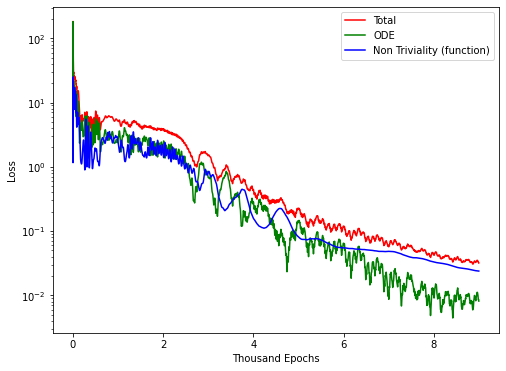

In [14]:
plt.figure(figsize = (8,6))
plt.semilogy(np.arange(9001)/1000,loss_hists[0],'-r', label = 'Total')
plt.semilogy(np.arange(9001)/1000,loss_hists[1],'-g', label = 'ODE')
plt.semilogy(np.arange(9001)/1000,loss_hists[2],'-b', label = 'Non Triviality (function)')
plt.ylabel('Loss');plt.xlabel('Thousand Epochs')
plt.legend()

# Frequencies

Text(0.5, 0, 'Thousand Epochs')

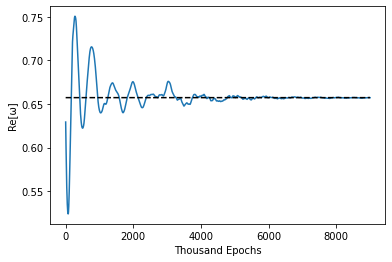

In [22]:
plt.plot(np.arange(9001), FreqRe)
plt.plot(range(9001), np.ones(9001)*.6572 , "k--")
plt.ylabel('Re[ω]');plt.xlabel('Thousand Epochs')

Text(0.5, 0, 'Thousand Epochs')

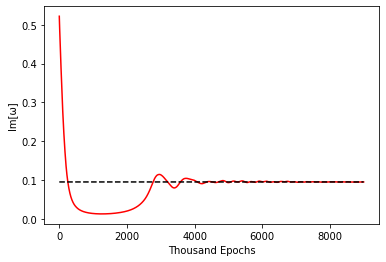

In [23]:
plt.plot(np.arange(9001), FreqIm,"r-")
plt.plot(range(9001), np.ones(9001)*.09549 , "k--")
plt.ylabel('Im[ω]');plt.xlabel('Thousand Epochs')

# QNM

## Compressed coordinartes (parametrized)

In [149]:
#Solution Domain
X = torch.linspace(x0,xf,n_train*10)
X = X.reshape(-1,1)
X.requires_grad=True
X_numpy = X.detach().numpy()

In [150]:
#Predicted solutions
ψR_p_χ = model[0][0](X)[0][:,0].detach().numpy()
ψI_p_χ = model[0][0](X)[0][:,1].detach().numpy()

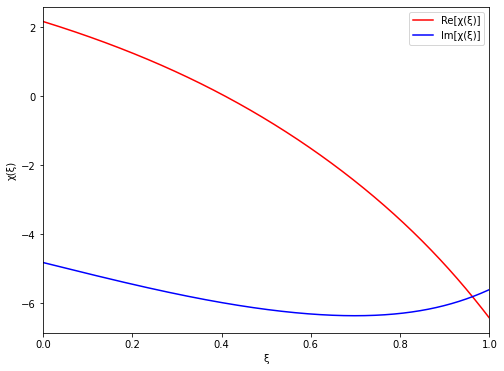

In [151]:
plt.figure(figsize = (8,6))
plt.plot(X_numpy, ψR_p_χ, '-r', label = 'Re[χ(ξ)]')
plt.plot(X_numpy, ψI_p_χ, '-b', label = 'Im[χ(ξ)]')
plt.ylabel('χ(ξ)');plt.xlabel('ξ')
plt.xlim([0,1])
plt.legend()

## Compressed coordinartes

In [152]:
#Complex frequency
ω = (FreqRe[-1] - FreqIm[-1]*1j) 
#Parametrization 
Ψ_χ = (X_numpy**(-2j*M*ω))*((1 - X_numpy)**(-2j*M*ω))*np.exp((2j*M*ω)/(1 - X_numpy))*(ψR_p_χ + ψI_p_χ*1j).reshape((-1,1)) 
ψR_χ = np.real(Ψ_χ) # Real part
ψI_χ = np.imag(Ψ_χ) # Imaginary part

/var/folders/x1/5n0q4k651yn3nwgl1ql4f9jc0000gn/T/ipykernel_1498/4240258691.py:4: RuntimeWarning: invalid value encountered in power
  Ψ_χ = (X_numpy**(-2j*M*ω))*((1 - X_numpy)**(-2j*M*ω))*np.exp((2j*M*ω)/(1 - X_numpy))*(ψR_p_χ + ψI_p_χ*1j).reshape((-1,1))
/var/folders/x1/5n0q4k651yn3nwgl1ql4f9jc0000gn/T/ipykernel_1498/4240258691.py:4: RuntimeWarning: divide by zero encountered in true_divide
  Ψ_χ = (X_numpy**(-2j*M*ω))*((1 - X_numpy)**(-2j*M*ω))*np.exp((2j*M*ω)/(1 - X_numpy))*(ψR_p_χ + ψI_p_χ*1j).reshape((-1,1))
/var/folders/x1/5n0q4k651yn3nwgl1ql4f9jc0000gn/T/ipykernel_1498/4240258691.py:4: RuntimeWarning: overflow encountered in exp
  Ψ_χ = (X_numpy**(-2j*M*ω))*((1 - X_numpy)**(-2j*M*ω))*np.exp((2j*M*ω)/(1 - X_numpy))*(ψR_p_χ + ψI_p_χ*1j).reshape((-1,1))
/var/folders/x1/5n0q4k651yn3nwgl1ql4f9jc0000gn/T/ipykernel_1498/4240258691.py:4: RuntimeWarning: invalid value encountered in exp
  Ψ_χ = (X_numpy**(-2j*M*ω))*((1 - X_numpy)**(-2j*M*ω))*np.exp((2j*M*ω)/(1 - X_numpy))*(ψR_p_χ + ψI_p_

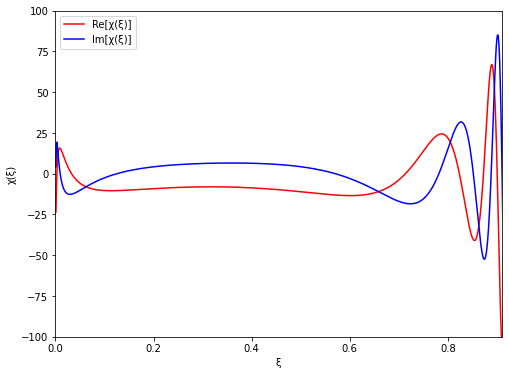

In [153]:
plt.figure(figsize = (8,6))
plt.plot(X_numpy, ψR_χ, '-r', label = 'Re[χ(ξ)]')
plt.plot(X_numpy, ψI_χ, '-b', label = 'Im[χ(ξ)]')
plt.ylabel('χ(ξ)');plt.xlabel('ξ')
plt.xlim([0,.91])
plt.ylim([-100,100])
plt.legend()

## Radial coordinates

/var/folders/x1/5n0q4k651yn3nwgl1ql4f9jc0000gn/T/ipykernel_1498/1068868657.py:1: RuntimeWarning: divide by zero encountered in true_divide
  r = 2*M/(1-X_numpy) #radial coordinate


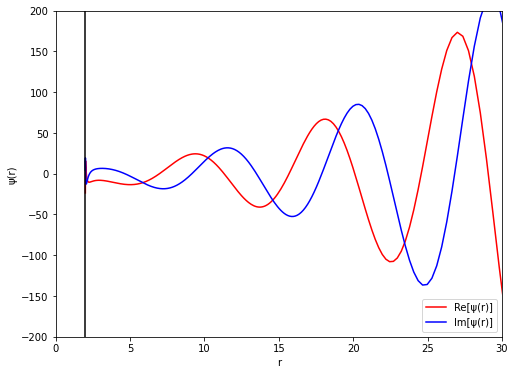

In [154]:
r = 2*M/(1-X_numpy) #radial coordinate
plt.figure(figsize = (8,6))
plt.plot(r, ψR_χ, '-r', label = 'Re[ψ(r)]')
plt.plot(r, ψI_χ, '-b', label = 'Im[ψ(r)]')
plt.axvline(x = 2*M, color = 'k')
plt.ylabel('ψ(r)');plt.xlabel('r')
plt.xlim([0,30])
plt.ylim([-200,200])
plt.legend()